In [1]:
import pandas as pd
import numpy as np 
import seaborn as sns
from sklearn.metrics import accuracy_score

# Reconocimiento de dígitos con KNN+PCA



Definir los path al ejecutable de python 3.6 y sus librerías,
de acuerdo al virtual env que estén corriendo.

In [2]:
!cd .. && mkdir build
!cd ../build/ && rm -rf *
!cd ../build && cmake \
  -DPYTHON_EXECUTABLE="$(which python)" \
  -DCMAKE_BUILD_TYPE=Release ..
!cd ../build && make install

mkdir: cannot create directory ‘build’: File exists
-- The C compiler identification is GNU 9.3.0
-- The CXX compiler identification is GNU 9.3.0
-- Check for working C compiler: /usr/bin/cc
-- Check for working C compiler: /usr/bin/cc -- works
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Detecting C compile features
-- Detecting C compile features - done
-- Check for working CXX compiler: /usr/bin/c++
-- Check for working CXX compiler: /usr/bin/c++ -- works
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Detecting CXX compile features
-- Detecting CXX compile features - done
Release mode
-- Found PythonInterp: /home/gianluca/Documents/Metodos Numericos/tp2/bin/python (found version "3.8.5") 
-- Found PythonLibs: /usr/lib/x86_64-linux-gnu/libpython3.8.so
-- pybind11 v2.2.4
-- Performing Test HAS_FLTO
-- Performing Test HAS_FLTO - Success
-- LTO enabled
CMAKE_INSTALL_PREFIX=/home/gianluca/Documents/Metodos Numericos/github_g

In [3]:
# Verifico la correcta instalación. Si no falla el import está OK
!pwd
!python --version
import metnum


/home/gianluca/Documents/Metodos Numericos/github_grupal/metodos-num/tp2/notebooks
Python 3.8.5


In [4]:
def pca(alpha, train,validacion):
    pca= metnum.PCA(alpha)
    pca.fit(train)
    train_pca = pca.transform(train)
    val_pca = pca.transform(validacion)
    return train_pca, val_pca


In [91]:
def trainYvalidacion(k,alpha,X,y,X_val,y_val):
    X_pca, X_val_pca = pca(alpha,X,X_val)

    clf = metnum.KNNClassifier(k)
    clf.fit(X_pca, y)
    clf.load(X_val_pca)
    y_pred = clf.predict(k)

    acc = accuracy_score(y_val, y_pred)
    print("Accuracy: {}".format(acc))
    recall    = recall_score(y_val, y_pred,average = None)
    precision = precision_score(y_val, y_pred, average=None)
    f1        = f1_score(y_val, y_pred, average = None)
    return acc,recall,precision, f1,y_pred

In [6]:
def numpy_to_csv(x,val,alpha,nset):
    df_x = pd.DataFrame(data=x)
    df_x.to_csv(f"transformaciones/{nset}_{alpha}_train.csv",index=False)
    df_val = pd.DataFrame(data=val)
    df_val.to_csv(f"transformaciones/{nset}_{alpha}_val.csv",index=False)

In [33]:
%load_ext autoreload
%autoreload 2

df_train = pd.read_csv("../data/train.csv")
print(df_train.info())

X = df_train[df_train.columns[1:]].values
y = df_train["label"].values.reshape(-1, 1)

X.shape, y.shape

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB
None


((42000, 784), (42000, 1))

# Experimento Preliminar 

Analizamos sobre una particion del dataset (5000) con el objetivo de conseguir una primera intuición con respecto al metodo.

In [174]:
#Mezclamos la data original
idx = np.random.permutation(len(X))
X,y = X[idx], y[idx]
#Tomamamos los primeros 5000 datos
X,y = X[:5000],y[:5000]
X.shape,y.shape

((5000, 784), (5000, 1))

In [8]:
limit = int(0.8 * X.shape[0]) 

X_train, y_train = X[:limit], y[:limit]
X_val, y_val = X[limit:], y[limit:]

assert len(X_train) == len(y_train)
assert len(X_val) == len(y_val)

print(f"Ahora tengo {len(X_train)} instancias de entrenamiento y {len(X_val)} de validación")

Ahora tengo 33600 instancias de entrenamiento y 8400 de validación


In [191]:
alpha_max = 300
k_max = 150
salto_alpha = 10
salto_k = 10

alphas = [1] + [i*salto_alpha for i in range(1, int(alpha_max/salto_alpha) + 1)]
Ks = [1] + [i*salto_k for i in range(1,int(k_max/salto_k) + 1)]
#alphas , Ks

In [192]:
X_pca_max, X_val_pca_max = pca(alpha_max,X_train,X_val)

In [193]:
from timeit import default_timer as timer
start = timer()

col_alphas = []
col_k = []
accuracy = []

for alpha in alphas :
    
    X_pca, X_val_pca = X_pca_max[0:, 0:alpha], X_val_pca_max[0:, 0:alpha]
    
    for k in Ks :
        
        clf = metnum.KNNClassifier(k)
        clf.fit(X_pca, y_train)
        y_pred = clf.predict(X_val_pca)
        acc = accuracy_score(y_val, y_pred)
        
        #para armar dsp el dataframe
        accuracy.append(acc)
        col_alphas.append(alpha)
        col_k.append(k)

        
        
end = timer()
print(end - start)

203.2839509339974


In [194]:
dat = pd.DataFrame({"Alpha":col_alphas,"K":col_k,"Accuracy": accuracy})
dat.sort_values(by=['Accuracy'],ascending = False).head(30)

,Alpha,K,Accuracy
113,70,10,0.943
97,60,10,0.942
65,40,10,0.942
353,220,10,0.941
273,170,10,0.940
145,90,10,0.940
289,180,10,0.940
81,50,10,0.940
129,80,10,0.940
337,210,10,0.940


In [195]:
#Guardar csv
dat.to_csv("exp_csv/PreliminarValidacionSimple.csv",index = True,header = True)

Recuperamos los datos guardados

In [196]:
#Reshape DataFrame
prel = pd.read_csv("exp_csv/PreliminarValidacionSimple.csv")
prel_reshape = prel.pivot("Alpha","K","Accuracy")
prel_reshape

K,1,10,20,30,40,50,60,70,80,90,100,110,120,130,140,150
Alpha,,,,,,,,,,,,,,,,
1,0.229,0.298,0.294,0.302,0.291,0.291,0.292,0.298,0.309,0.302,0.311,0.306,0.304,0.304,0.298,0.304
10,0.864,0.886,0.884,0.884,0.878,0.882,0.870,0.866,0.859,0.854,0.849,0.847,0.838,0.834,0.830,0.827
20,0.915,0.927,0.919,0.917,0.912,0.909,0.901,0.896,0.886,0.887,0.882,0.876,0.875,0.873,0.870,0.864
30,0.937,0.938,0.937,0.927,0.919,0.911,0.909,0.901,0.893,0.885,0.883,0.878,0.875,0.870,0.871,0.866
40,0.937,0.942,0.934,0.924,0.916,0.907,0.899,0.895,0.893,0.890,0.883,0.879,0.879,0.874,0.861,0.859
50,0.931,0.940,0.931,0.922,0.907,0.905,0.898,0.896,0.889,0.885,0.879,0.879,0.871,0.863,0.852,0.844
60,0.933,0.942,0.924,0.916,0.911,0.904,0.899,0.894,0.886,0.881,0.879,0.864,0.864,0.857,0.848,0.838
70,0.929,0.943,0.925,0.912,0.909,0.896,0.893,0.887,0.880,0.874,0.873,0.867,0.858,0.848,0.840,0.832
80,0.932,0.940,0.924,0.909,0.905,0.900,0.886,0.883,0.877,0.871,0.865,0.857,0.850,0.841,0.833,0.831


Se puede observar una tendencia hacia valores chicos de k y a una diferencia no muy grande con respecto a los alphas con esos k .

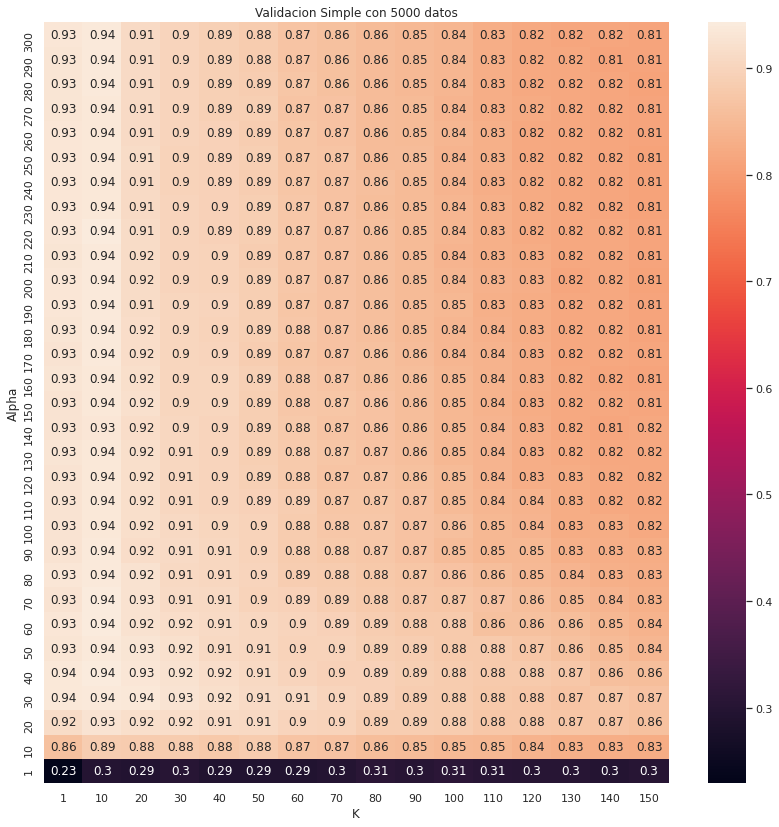

In [204]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
plt.figure(figsize=(14,14))
hmap = sns.heatmap(prel_reshape,annot = True)    #,annot = True)#,cmap = "YlGnBu") # colores de mapa claros
hmap.invert_yaxis()
plt.title("Validacion Simple con 5000 datos")
plt.show()
#plt.savefig("exp_csv/plots/validacionSimple_heatmap.png")

# Accuracy validacion simple sobre el dataset completo

Buscamos las mejores parejas sobre un rango amplio de alpha y k , utilizando un split simple de 33600 instancias de entrenamiento y 8400 de validación.


In [34]:
#Mezclamos la data original
np.random.seed(30)
idx = np.random.permutation(len(X))
X,y = X[idx], y[idx]

X.shape,y.shape

((42000, 784), (42000, 1))

In [35]:
limit = int(0.8 * X.shape[0]) 

X_train, y_train = X[:limit], y[:limit]
X_val, y_val = X[limit:], y[limit:]

assert len(X_train) == len(y_train)
assert len(X_val) == len(y_val)

print(f"Ahora tengo {len(X_train)} instancias de entrenamiento y {len(X_val)} de validación")


Ahora tengo 33600 instancias de entrenamiento y 8400 de validación


In [14]:
alpha_max = 165
k_max = 150
salto_alpha = 5
salto_k = 2

alphas = [1] + [i*salto_alpha for i in range(1, int(alpha_max/salto_alpha) + 1)]
Ks = [1] + [i*salto_k for i in range(1,int(k_max/salto_k) + 1)]
#alphas , Ks

In [15]:
X_pca_max, X_val_pca_max = pca(alpha_max,X_train,X_val)

In [16]:
from timeit import default_timer as timer
start = timer()

col_alphas = []
col_k = []
accuracy = []

for alpha in alphas :
    
    X_pca, X_val_pca = X_pca_max[0:, 0:alpha], X_val_pca_max[0:, 0:alpha]
    
    for k in Ks :
        
        clf = metnum.KNNClassifier(k)
        clf.fit(X_pca, y_train)
        y_pred = clf.predict(X_val_pca)
        acc = accuracy_score(y_val, y_pred)
        
        #para armar dsp el dataframe
        accuracy.append(acc)
        col_alphas.append(alpha)
        col_k.append(k)

        
        
end = timer()
print(end - start)

KeyboardInterrupt: 

In [18]:
indmax = accuracy.index(max(accuracy))

best_alpha = col_alphas[indmax]
best_k = col_k[indmax]
print(f" Mejor (alpha, k): ({col_alphas[indmax]}, {col_k[indmax]})")
print(f"Accuracy : {accuracy[indmax]}" )

 Mejor (alpha, k): (50, 6)
Accuracy : 0.9736904761904762


In [60]:
dat = pd.DataFrame({"Alpha":col_alphas,"K":col_k,"Accuracy": accuracy})
dat,dat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2557 entries, 0 to 2556
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Alpha     2557 non-null   int64  
 1   K         2557 non-null   int64  
 2   Accuracy  2557 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 60.1 KB


(      Alpha   K  Accuracy
 0         1   1  0.256905
 1         1   2  0.242024
 2         1   4  0.276310
 3         1   6  0.277738
 4         1   8  0.281548
 ...     ...  ..       ...
 2552    165  88  0.938095
 2553    165  90  0.938095
 2554    165  92  0.937619
 2555    165  94  0.937619
 2556    165  96  0.937024
 
 [2557 rows x 3 columns],
 None)

In [27]:
#Guardar csv
dat.to_csv("exp_csv/validacionSimple.csv",index = False,header = True)


Recuperamos datos guardados

In [10]:
#Reshape DataFrame
val_simple = pd.read_csv("exp_csv/validacionSimple.csv")
val_simple_reshape = val_simple.pivot("Alpha","K","Accuracy")
val_simple_reshape

K,1,2,4,6,8,10,12,14,16,18,...,132,134,136,138,140,142,144,146,148,150
Alpha,,,,,,,,,,,,,,,,,,,,,
1,0.256905,0.242024,0.276310,0.277738,0.281548,0.282857,0.285000,0.289048,0.287262,0.286667,...,0.303690,0.304524,0.302857,0.304286,0.303095,0.305000,0.304048,0.305595,0.305595,0.305595
5,0.686786,0.688095,0.725952,0.738333,0.740952,0.748333,0.752976,0.754524,0.755357,0.755833,...,0.744643,0.745357,0.743929,0.743929,0.743095,0.742857,0.743333,0.742262,0.742857,0.742619
10,0.907857,0.901905,0.920476,0.922143,0.922857,0.923690,0.922857,0.921548,0.921190,0.919524,...,0.897976,0.897738,0.897500,0.897024,0.896429,0.896071,0.896310,0.895714,0.896190,0.895476
15,0.949405,0.942024,0.954048,0.952976,0.951786,0.951310,0.952143,0.951310,0.949524,0.950119,...,0.924048,0.923214,0.922619,0.922976,0.922143,0.922262,0.921667,0.921905,0.921548,0.920952
20,0.962738,0.955952,0.966190,0.965595,0.964643,0.963810,0.962500,0.962857,0.962500,0.960357,...,0.936548,0.935833,0.936190,0.935714,0.936190,0.935357,0.934405,0.934286,0.934167,0.933810
25,0.965119,0.963810,0.970357,0.970357,0.969405,0.967619,0.966071,0.966310,0.965238,0.965119,...,0.940952,0.940357,0.940000,0.939881,0.939405,0.939048,0.938690,0.938333,0.938095,0.937381
30,0.968214,0.964762,0.971667,0.971667,0.971310,0.970357,0.969643,0.969881,0.968690,0.967738,...,0.942500,0.942024,0.942143,0.941786,0.942143,0.941667,0.941667,0.941429,0.941310,0.940952
35,0.970476,0.965595,0.972143,0.972857,0.972619,0.971190,0.968929,0.968095,0.968571,0.967738,...,0.943571,0.942976,0.943095,0.942262,0.942500,0.942381,0.941905,0.941310,0.940952,0.940476
40,0.971310,0.966786,0.972381,0.972976,0.972024,0.970357,0.969524,0.968452,0.967381,0.967738,...,0.941786,0.941548,0.941429,0.940595,0.941071,0.940952,0.940833,0.940952,0.940476,0.939881


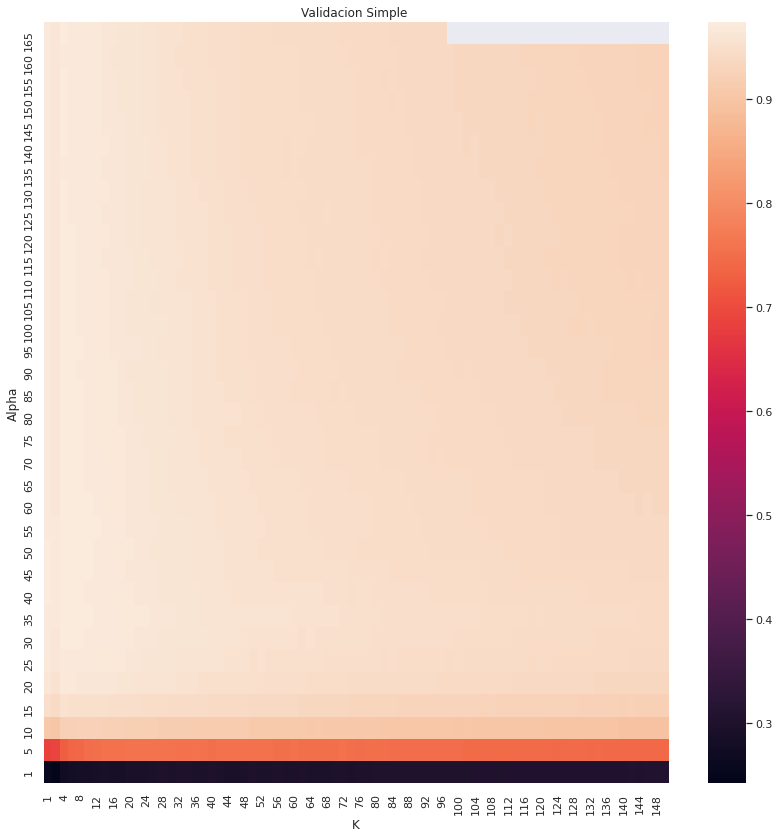

In [11]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
plt.figure(figsize=(14,14))
hmap = sns.heatmap(val_simple_reshape)    #,annot = True)#,cmap = "YlGnBu") # colores de mapa claros
hmap.invert_yaxis()
plt.title("Validacion Simple ")
#plt.savefig("exp_csv/plots/validacionSimple_heatmap.png") 
plt.show()

Filtramos algunos parametros del dataset para visualizar mejor los resultados. En particular omitimos el alpha maximo 165 y los primeros tres alphas( 1,5,10) ya que sus resultados eran de los peores .

<ipython-input-11-bbb1592e9372>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  val_simple= val_simple[filtro][filtro2]


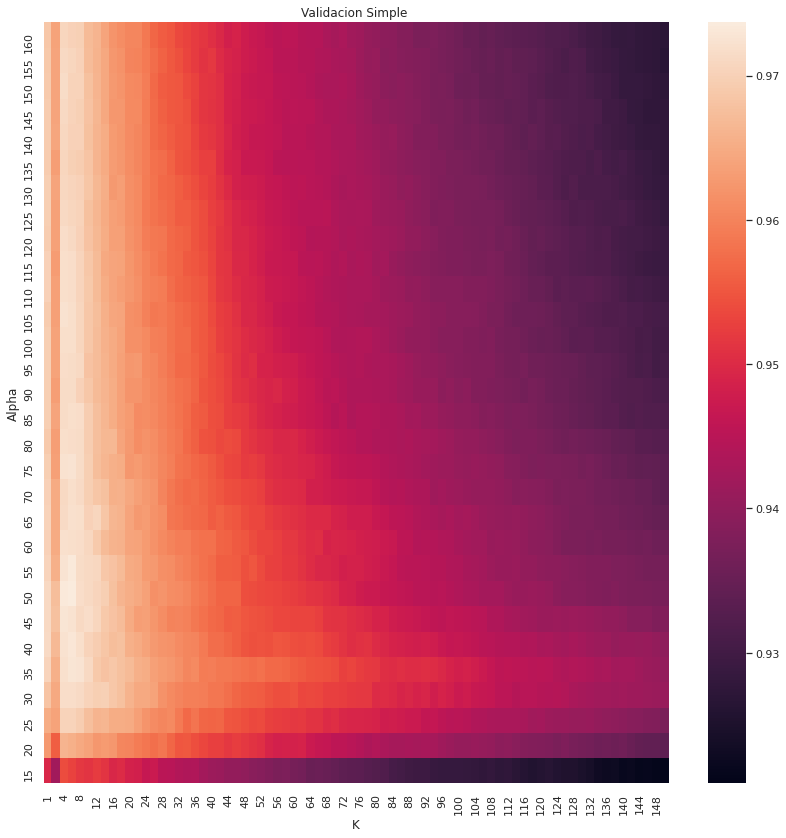

In [11]:
#Limpieza para visualizar mejor el heatmap

filtro = val_simple["Alpha"] > 10  
filtro2 =165 > val_simple["Alpha"]
val_simple= val_simple[filtro][filtro2]
val_simple_reshape = val_simple.pivot("Alpha","K","Accuracy")

plt.figure(figsize=(14,14))
hmap = sns.heatmap(val_simple_reshape)    #,annot = True)#,cmap = "YlGnBu") # colores de mapa claros
hmap.invert_yaxis()
plt.title("Validacion Simple ")
plt.show()

# Cross Validation

Extraemos de la validacion simple los parametros de las mejores 10 parejas para luego hacer CV con ellas.

In [16]:
val_simple.sort_values(by=['Accuracy'],ascending = False).head(10)

,Alpha,K,Accuracy
763,50,6,0.973690
762,50,4,0.973452
839,55,6,0.973333
611,40,6,0.972976
535,35,6,0.972857
686,45,4,0.972857
536,35,8,0.972619
1143,75,6,0.972619
838,55,4,0.972619
687,45,6,0.972381


In [17]:
mejores_k = val_simple.sort_values(by=['Accuracy'],ascending = False).head(10)["K"].unique()
mejores_k = list(map(int, mejores_k))
mejores_k.sort()
mejores_k

[4, 6, 8]

In [18]:
mejores_alphas = val_simple.sort_values(by=['Accuracy'],ascending = False).head(10)["Alpha"].unique()
mejores_alphas = list(mejores_alphas)
mejores_alphas.sort()
mejores_alphas


[35, 40, 45, 50, 55, 75]

In [53]:
kFold

10

In [54]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, recall_score, f1_score, cohen_kappa_score, precision_score
def crossValidation(X, y, n_kfold,alphas,kNN_ks):

    cv_acc = {} 
  
    for alpha in mejores_alphas: 
        for k in mejores_k:
            cv_acc[(alpha,k)] = n_kfold*[0]
    
    
    alpha_max = max(mejores_alphas)
    kNN_k_max = max(kNN_ks)
    kf = KFold(n_splits=n_kfold)
    i = 0
    for train_index, test_index in kf.split(X):
        print(
                f"""
                    i_esimo kfold={i+1}/{n_kfold} 
                    
                """
                )
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        
        X_train_pca_max, X_test_pca_max = pca(alpha_max, X_train,X_test)

        for alpha in alphas :
            X_train_pca, X_test_pca = X_train_pca_max[0:, 0:alpha], X_test_pca_max[0:, 0:alpha]
            
            
            clf = metnum.KNNClassifier(kNN_k_max)
            clf.fit(X_train_pca, y_train)
            clf.load(X_test_pca)
            
            for k in kNN_ks :
                
                
                y_pred = clf.predict(k)
                #af=gregar al scope
                cv_acc[(alpha,k)][i] = accuracy_score(y_test, y_pred)
                
                #data.append({
                #    "train_size": X.shape[0],
                #    "knn": k,
                #    "alpha": alpha,
                #    "kfold": n_kfold,
                #    "accuracy": accuracy_score(y_test, y_pred),
                #    "recall": recall_score(y_test, y_pred, average = 'weighted'),
                #    "f1": f1_score(y_test, y_pred, average = 'weighted'),
                #    "cohen_kappa": cohen_kappa_score(y_test, y_pred),
                #    "precision": precision_score(y_test, y_pred, average = 'weighted'),
                #})

        i += 1
        
    return cv_acc

Utilizamos el mismo split previamente hecho en Validacion Simple

In [55]:
from timeit import default_timer as timer
start = timer()

resultCV = crossValidation(X_train,y_train,10,mejores_alphas,mejores_k)
        
end = timer()
print(end - start)


                    i_esimo kfold=1/10 
                    
                

                    i_esimo kfold=2/10 
                    
                

                    i_esimo kfold=3/10 
                    
                

                    i_esimo kfold=4/10 
                    
                

                    i_esimo kfold=5/10 
                    
                

                    i_esimo kfold=6/10 
                    
                

                    i_esimo kfold=7/10 
                    
                

                    i_esimo kfold=8/10 
                    
                

                    i_esimo kfold=9/10 
                    
                

                    i_esimo kfold=10/10 
                    
                
460.9640211570004


In [88]:
dfCV = pd.DataFrame(resultCV)
dfCV.to_csv("exp_csv/CrossValidation_knnpca.csv",index = False)
dfCV

35                            40                            45  \
          4         6         8         4         6         8         4   
0  0.972024  0.972917  0.972321  0.971131  0.971726  0.971726  0.970238   
1  0.973214  0.973810  0.972917  0.975893  0.972619  0.972024  0.974702   
2  0.979762  0.977679  0.976786  0.979464  0.978571  0.976786  0.979167   
3  0.973512  0.972619  0.972619  0.973214  0.971726  0.972917  0.972619   
4  0.966964  0.966667  0.965476  0.964583  0.965179  0.965774  0.964881   
5  0.966369  0.969345  0.969345  0.965774  0.970536  0.969643  0.966667   
6  0.966667  0.966071  0.966667  0.967262  0.966369  0.965179  0.967262   
7  0.972321  0.972321  0.973810  0.974405  0.972619  0.972619  0.972917   
8  0.970238  0.972024  0.970238  0.972321  0.971726  0.971429  0.973214   
9  0.971131  0.970238  0.969940  0.972321  0.971429  0.972321  0.969940   

                             50                            55            \
          6         8         4         6         8         4         6   
0  0.972321  0.971429  0.970238  0.972321  0.970833  0.968750  0.972321   
1  0.973214  0.970536  0.974107  0.974107  0.971131  0.973512  0.972619   
2  0.976190  0.976190  0.979464  0.978274  0.975893  0.979464  0.977976   
3  0.975595  0.973512  0.974107  0.972321  0.972024  0.972917  0.971429   
4  0.966369  0.965476  0.965476  0.966369  0.965774  0.967262  0.967857   
5  0.967560  0.969940  0.965774  0.969345  0.969643  0.967560  0.970536   
6  0.965476  0.966369  0.966369  0.965476  0.965774  0.966071  0.965774   
7  0.972917  0.972321  0.973512  0.971726  0.971726  0.972321  0.971131   
8  0.971726  0.969048  0.970536  0.969048  0.968155  0.969643  0.968452   
9  0.970536  0.971726  0.971131  0.969048  0.969643  0.969345  0.970238   

                   75                      
          8         4         6         8  
0  0.971726  0.972024  0.969643  0.969048  
1  0.971131  0.972024  0.971131  0.970238  
2  0.974702  0.979464  0.977381  0.973810  
3  0.971429  0.973512  0.971429  0.967857  
4  0.966071  0.965179  0.966071  0.965476  
5  0.968750  0.966369  0.969048  0.967560  
6  0.965179  0.966369  0.966369  0.964286  
7  0.971726  0.971429  0.972321  0.971131  
8  0.968452  0.969940  0.969345  0.968155  
9  0.971726  0.968155  0.968750  0.969940

## Recuperamos datos guardados

In [87]:
dfCV = pd.read_csv("exp_csv/CrossValidation_knnpca.csv")
dfCV

,35,35.1,35.2,40,40.1,40.2,45,45.1,45.2,50,50.1,50.2,55,55.1,55.2,75,75.1,75.2
0,4.000000,6.000000,8.000000,4.000000,6.000000,8.000000,4.000000,6.000000,8.000000,4.000000,6.000000,8.000000,4.000000,6.000000,8.000000,4.000000,6.000000,8.000000
1,0.972024,0.972917,0.972321,0.971131,0.971726,0.971726,0.970238,0.972321,0.971429,0.970238,0.972321,0.970833,0.968750,0.972321,0.971726,0.972024,0.969643,0.969048
2,0.973214,0.973810,0.972917,0.975893,0.972619,0.972024,0.974702,0.973214,0.970536,0.974107,0.974107,0.971131,0.973512,0.972619,0.971131,0.972024,0.971131,0.970238
3,0.979762,0.977679,0.976786,0.979464,0.978571,0.976786,0.979167,0.976190,0.976190,0.979464,0.978274,0.975893,0.979464,0.977976,0.974702,0.979464,0.977381,0.973810
4,0.973512,0.972619,0.972619,0.973214,0.971726,0.972917,0.972619,0.975595,0.973512,0.974107,0.972321,0.972024,0.972917,0.971429,0.971429,0.973512,0.971429,0.967857
5,0.966964,0.966667,0.965476,0.964583,0.965179,0.965774,0.964881,0.966369,0.965476,0.965476,0.966369,0.965774,0.967262,0.967857,0.966071,0.965179,0.966071,0.965476
6,0.966369,0.969345,0.969345,0.965774,0.970536,0.969643,0.966667,0.967560,0.969940,0.965774,0.969345,0.969643,0.967560,0.970536,0.968750,0.966369,0.969048,0.967560
7,0.966667,0.966071,0.966667,0.967262,0.966369,0.965179,0.967262,0.965476,0.966369,0.966369,0.965476,0.965774,0.966071,0.965774,0.965179,0.966369,0.966369,0.964286
8,0.972321,0.972321,0.973810,0.974405,0.972619,0.972619,0.972917,0.972917,0.972321,0.973512,0.971726,0.971726,0.972321,0.971131,0.971726,0.971429,0.972321,0.971131
9,0.970238,0.972024,0.970238,0.972321,0.971726,0.971429,0.973214,0.971726,0.969048,0.970536,0.969048,0.968155,0.969643,0.968452,0.968452,0.969940,0.969345,0.968155


In [89]:
dfCV.mean()

35  4    0.971220
    6    0.971369
    8    0.971012
40  4    0.971637
    6    0.971250
    8    0.971042
45  4    0.971161
    6    0.971190
    8    0.970655
50  4    0.971071
    6    0.970804
    8    0.970060
55  4    0.970685
    6    0.970833
    8    0.970089
75  4    0.970446
    6    0.970149
    8    0.968750
dtype: float64

In [85]:
resultadosOrdenados = dfCV.mean().sort_values(ascending = False)
resultadosOrdenados

40  4    0.971637
35  6    0.971369
40  6    0.971250
35  4    0.971220
45  6    0.971190
    4    0.971161
50  4    0.971071
40  8    0.971042
35  8    0.971012
55  6    0.970833
50  6    0.970804
55  4    0.970685
45  8    0.970655
75  4    0.970446
    6    0.970149
55  8    0.970089
50  8    0.970060
75  8    0.968750
dtype: float64

In [83]:
bestAlpha_cv = 40
bestK_cv = 4
print(f"Mejor pareja de cross validation :(Alpha,k) = {bestAlpha_cv}, {bestK_cv}" )

Mejor pareja de cross validation :(Alpha,k) = 40, 4


# Train y test con la mejor pareja de Cross Validation


In [92]:
acc,recall,precision,f1,pred = trainYvalidacion(4,40,X_train,y_train,X_val,y_val)

Accuracy: 0.9725


## Accuracy de Testing sobre la mejor pareja : 0.9725

In [93]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_val,pred,normalize = "true")
#PONEMOS CEROS EN LA DIAGONAL PARA VISUALIZAR MEJOR EL HEATPMAP
np.fill_diagonal(cm, 0, wrap=False)

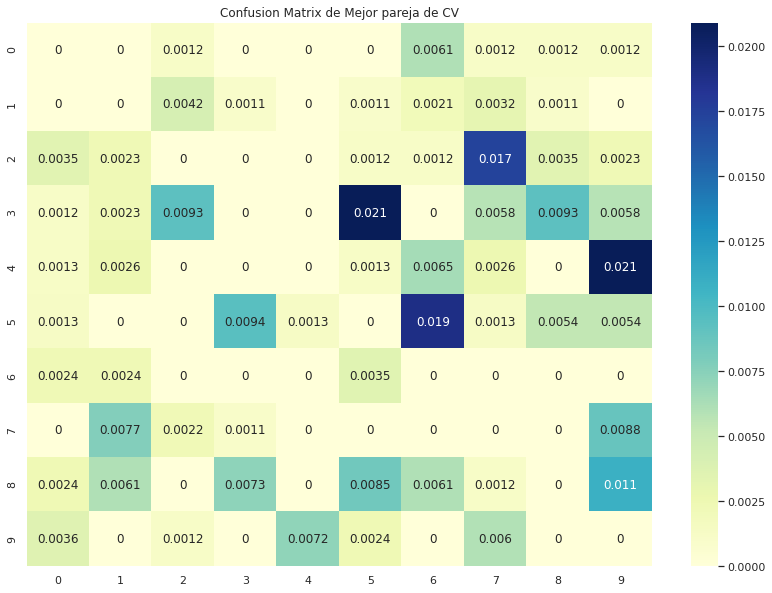

In [94]:
import matplotlib.pyplot as plt
plt.figure(figsize=(14,10))
sns.heatmap(cm,cmap = "YlGnBu",annot = True)
plt.title("Confusion Matrix de Mejor pareja de CV")
plt.show()

# Prestar atencion a la escala de cada ploteo , se encuentran de tal manera de modo que se visualicen mejor las diferencias entre clases.

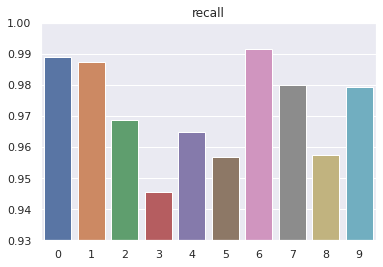

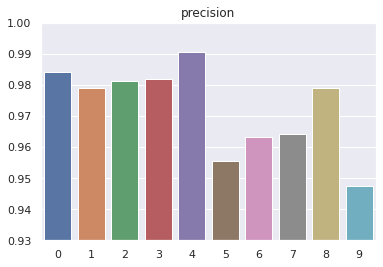

In [97]:
import matplotlib.pyplot as plt
ejex = [i for i in range(10)]
sns.barplot(x = ejex , y = recall)
plt.ylim(0.93, 1)
plt.title("recall")
plt.show()
sns.barplot(x = ejex , y = precision)
plt.ylim(0.93, 1)
plt.title("precision")
plt.show()